In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(tidyr))

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”


In [2]:
df <- readRDS("../Data/full_hourly_chunks.rds")

In [3]:
df <- df %>% mutate(starttime = as.POSIXct(starttime, format="%Y-%m-%d %H:%M:%S",tz="GMT"))
names(df)[names(df) == "Freq"] <- "texts"
names(df)[names(df) == "starttime"] <- "chunk"

In [4]:
df <- df %>% mutate(localtime = strftime(chunk, format="%H:%M:%S"),GMTtime = strftime(chunk, format="%H:%M:%S",tz="GMT"), weekday = weekdays(chunk), month = month(chunk), year = year(chunk), quarter = quarter(chunk))

In [5]:
str(df)

#for (i in 1:(dim(df)[1])) {
#  if (df$GMTtime[i] == "05:00:00") {
#    df$texts[i] <- mean(df$texts[i+1],df$texts[i-1])
#  }
#}

'data.frame':	31687 obs. of  8 variables:
 $ chunk    : POSIXct, format: "2018-10-25 15:00:00" "2018-10-25 16:00:00" ...
 $ texts    : int  3 3 8 9 11 24 22 18 17 6 ...
 $ localtime: chr  "15:00:00" "16:00:00" "17:00:00" "18:00:00" ...
 $ GMTtime  : chr  "15:00:00" "16:00:00" "17:00:00" "18:00:00" ...
 $ weekday  : chr  "Thursday" "Thursday" "Thursday" "Thursday" ...
 $ month    : num  10 10 10 10 10 10 10 10 10 10 ...
 $ year     : num  2018 2018 2018 2018 2018 ...
 $ quarter  : int  4 4 4 4 4 4 4 4 4 4 ...


In [7]:
saveRDS(df, "../Data/5am_peak_cleaned.rds")

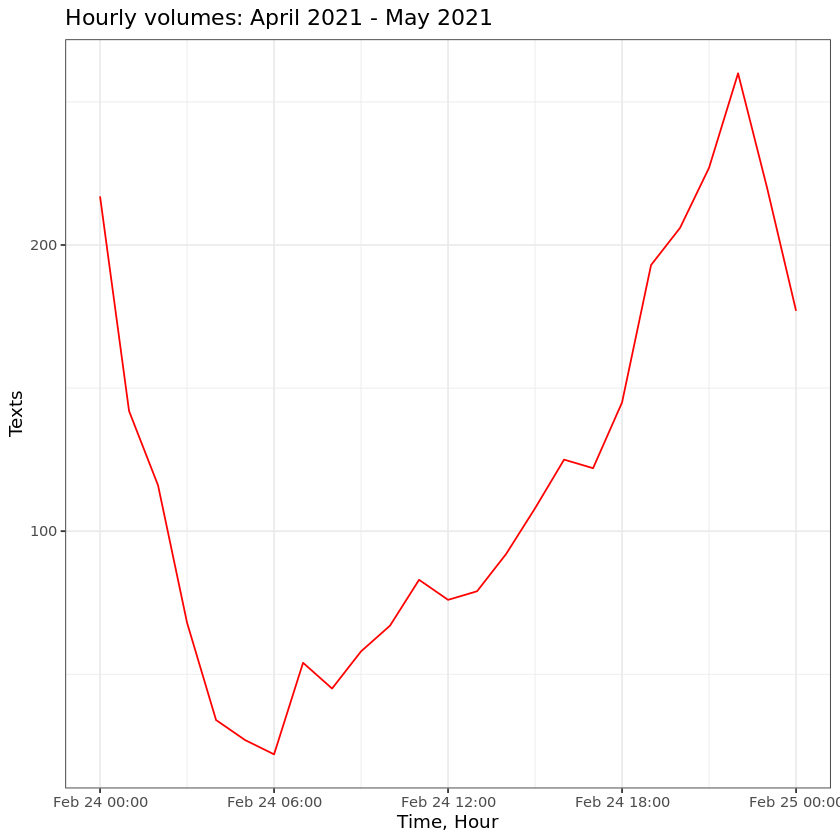

In [8]:
ggplot(dplyr::filter(df, chunk >= "2022-02-24" & chunk <= "2022-02-25"),aes(chunk,texts)) + geom_line(col="red") +
  theme_bw() + ggtitle("Hourly volumes: April 2021 - May 2021") + xlab("Time, Hour") +ylab("Texts")

In [9]:
head(df)

,chunk,texts,localtime,GMTtime,weekday,month,year,quarter
,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,2018-10-25 15:00:00,3,15:00:00,15:00:00,Thursday,10,2018,4
2,2018-10-25 16:00:00,3,16:00:00,16:00:00,Thursday,10,2018,4
3,2018-10-25 17:00:00,8,17:00:00,17:00:00,Thursday,10,2018,4
4,2018-10-25 18:00:00,9,18:00:00,18:00:00,Thursday,10,2018,4
5,2018-10-25 19:00:00,11,19:00:00,19:00:00,Thursday,10,2018,4
6,2018-10-25 20:00:00,24,20:00:00,20:00:00,Thursday,10,2018,4


In [10]:
tail(df)

,chunk,texts,localtime,GMTtime,weekday,month,year,quarter
,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
31682,2022-06-06 16:00:00,89,16:00:00,16:00:00,Monday,6,2022,2
31683,2022-06-06 17:00:00,104,17:00:00,17:00:00,Monday,6,2022,2
31684,2022-06-06 18:00:00,124,18:00:00,18:00:00,Monday,6,2022,2
31685,2022-06-06 19:00:00,140,19:00:00,19:00:00,Monday,6,2022,2
31686,2022-06-06 20:00:00,188,20:00:00,20:00:00,Monday,6,2022,2
31687,2022-06-06 21:00:00,144,21:00:00,21:00:00,Monday,6,2022,2


In [11]:
ci <- function(vector) {
  return(1.96*sd(vector)/sqrt(12))
}

In [6]:
years <- sort(unique(df$year))
quarters <- sort(unique(df$quarter))
months <- sort(unique(df$month))
hours <- sort(unique(df$GMTtime))
weekdays <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")

In [13]:
ci_high_df <- data.frame(Time=character(), ci_high=double())
abnormal <- data.frame(chunk=character(),abnormal=double())
for (year in years){
    for (quarter in quarters){
        quarter_text <- paste0("Q",quarter)
        year_quarter <- paste(quarter_text,year)
        for (weekday in weekdays) {
            year_quarter_weekday <- paste(year_quarter,weekday)
            for (hour in hours) {
                df_tmp <- df[df["weekday"] == weekday & df["GMTtime"] == hour & df["year"] == year & df["quarter"]== quarter,]
                ci_high_df[nrow(ci_high_df) + 1,] = c(paste(year_quarter_weekday,hour),mean(df_tmp$texts) + 1.96*sd(df_tmp$texts)/sqrt(nrow(df_tmp)))
                df_tmp$abnormal <- df_tmp$texts > (mean(df_tmp$texts) + 1.96*sd(df_tmp$texts)/sqrt(nrow(df_tmp)))
                abnormal <- rbind(abnormal, df_tmp[,c("chunk", "abnormal")])
            }
        }
    }
}

In [14]:
ci_high_df <- ci_high_df[!grepl("Q4 2022", ci_high_df$Time),]
ci_high_df <- ci_high_df[!grepl("Q3 2022", ci_high_df$Time),]
ci_high_df <- ci_high_df %>% separate(Time, c("quarter", "year", "weekday", "hour"), sep=" ")
ci_high_df$quarter = substr(ci_high_df$quarter,2,nchar(ci_high_df$quarter))

In [15]:
saveRDS(ci_high_df, "../Data/ci_high_df_quarterly.rds")

In [16]:
abnormal$abnormal <- as.numeric(abnormal$abnormal)
sum(abnormal$abnormal)
head(abnormal)

[1] 8205

,chunk,abnormal
,<dttm>,<dbl>
82,2018-10-29,0
250,2018-11-05,0
418,2018-11-12,0
586,2018-11-19,0
754,2018-11-26,0
922,2018-12-03,0


In [17]:
df <- merge(x=df, y=abnormal,by="chunk")
head(df)

,chunk,texts,localtime,GMTtime,weekday,month,year,quarter,abnormal
,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
1,2018-10-25 15:00:00,3,15:00:00,15:00:00,Thursday,10,2018,4,0
2,2018-10-25 16:00:00,3,16:00:00,16:00:00,Thursday,10,2018,4,0
3,2018-10-25 17:00:00,8,17:00:00,17:00:00,Thursday,10,2018,4,0
4,2018-10-25 18:00:00,9,18:00:00,18:00:00,Thursday,10,2018,4,0
5,2018-10-25 19:00:00,11,19:00:00,19:00:00,Thursday,10,2018,4,0
6,2018-10-25 20:00:00,24,20:00:00,20:00:00,Thursday,10,2018,4,1


In [18]:
write.csv(df, "../Data/abnormal_peaks.csv")

In [19]:
month_text <- c("January","February","March","April","May","June","July","August","September","October","November","December","January")

In [20]:
file_path <- "../Plots/Hourly_by_month/"
for (year in years) {
    for (month in months) {
        year_month_text <- paste(month_text[month],year)
        title_text <- paste("Hourly volumes: ", year_month_text)
        ggplot(df[df["year"]==year & df["month"]==month,],aes(chunk,texts)) + geom_line(col="red") +
          theme_bw() + ggtitle(paste(title_text,paste(month_text[month+1],year),sep=" - ")) + xlab("Time, Hour") +ylab("Texts")
        ggsave(paste(paste(file_path,paste(year_month_text,paste(month_text[month+1],year),sep="-")),".pdf",sep=""))
    }
}

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

In [33]:
df_dt <- df[,c("chunk", "texts","abnormal")]
df_dt <- df_dt[order(df_dt$chunk, decreasing=TRUE),]
head(df_dt)

,chunk,texts,abnormal
,<dttm>,<int>,<dbl>
31687,2022-06-06 21:00:00,144,0
31686,2022-06-06 20:00:00,188,1
31685,2022-06-06 19:00:00,140,1
31684,2022-06-06 18:00:00,124,1
31683,2022-06-06 17:00:00,104,1
31682,2022-06-06 16:00:00,89,0


In [23]:
shift <- function(x, n){
  c(x[-(seq(n))], rep(NA, n))
}

In [35]:
df_dt["1-hr"] <- shift(df_dt$texts, 1)
df_dt["2-hr"] <- shift(df_dt$texts, 2)
df_dt["3-hr"] <- shift(df_dt$texts, 3)
df_dt["4-hr"] <- shift(df_dt$texts, 4)
df_dt["5-hr"] <- shift(df_dt$texts, 5)
df_dt["6-hr"] <- shift(df_dt$texts, 6)
df_dt["7-hr"] <- shift(df_dt$texts, 7)
df_dt["8-hr"] <- shift(df_dt$texts, 8)
df_dt["9-hr"] <- shift(df_dt$texts, 9)
df_dt["10-hr"] <- shift(df_dt$texts, 10)
df_dt["11-hr"] <- shift(df_dt$texts, 11)
df_dt["12-hr"] <- shift(df_dt$texts, 12)
df_dt["13-hr"] <- shift(df_dt$texts, 13)
df_dt["14-hr"] <- shift(df_dt$texts, 14)
df_dt["15-hr"] <- shift(df_dt$texts, 15)
df_dt["16-hr"] <- shift(df_dt$texts, 16)
df_dt["17-hr"] <- shift(df_dt$texts, 17)
df_dt["18-hr"] <- shift(df_dt$texts, 18)
df_dt["19-hr"] <- shift(df_dt$texts, 19)
df_dt["20-hr"] <- shift(df_dt$texts, 20)
df_dt["21-hr"] <- shift(df_dt$texts, 21)
df_dt["22-hr"] <- shift(df_dt$texts, 22)
df_dt["23-hr"] <- shift(df_dt$texts, 23)
df_dt["24-hr"] <- shift(df_dt$texts, 24)
df_dt["25-hr"] <- shift(df_dt$texts, 25)
df_dt["26-hr"] <- shift(df_dt$texts, 26)
df_dt["27-hr"] <- shift(df_dt$texts, 27)
df_dt["28-hr"] <- shift(df_dt$texts, 28)

In [36]:
df_dt <- df_dt[order(df_dt$chunk),]
df_dt <- df_dt[29:(nrow(df_dt)-1),]
df_dt <- df_dt %>% select(-2)
head(df_dt)

,chunk,abnormal,1-hr,2-hr,3-hr,4-hr,5-hr,6-hr,7-hr,8-hr,⋯,19-hr,20-hr,21-hr,22-hr,23-hr,24-hr,25-hr,26-hr,27-hr,28-hr
,<dttm>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
29,2018-10-26 19:00:00,0,11,6,11,6,10,15,7,5,⋯,6,17,18,22,24,11,9,8,3,3
30,2018-10-26 20:00:00,0,17,11,6,11,6,10,15,7,⋯,7,6,17,18,22,24,11,9,8,3
31,2018-10-26 21:00:00,0,15,17,11,6,11,6,10,15,⋯,5,7,6,17,18,22,24,11,9,8
32,2018-10-26 22:00:00,0,15,15,17,11,6,11,6,10,⋯,1,5,7,6,17,18,22,24,11,9
33,2018-10-26 23:00:00,1,19,15,15,17,11,6,11,6,⋯,2,1,5,7,6,17,18,22,24,11
34,2018-10-27 00:00:00,0,21,19,15,15,17,11,6,11,⋯,0,2,1,5,7,6,17,18,22,24


In [37]:
write.csv(df_dt, "../Data/df_for_decision_tree.csv")

In [7]:
standardised <- data.frame(chunk=character(),standardised_texts=double(),abnormal=double())
abnormal_cutoffs <- data.frame(chunk=character(),cutoff=double())
abnormal_cutoffs_2sd <- data.frame(chunk=character(),cutoff=double())
abnormal_cutoffs_1.5sd <- data.frame(chunk=character(),cutoff=double())

for (year in years){
    for (quarter in quarters){
        for (weekday in weekdays) {
            for (hour in hours) {
                df_tmp <- df[df["weekday"] == weekday & df["GMTtime"] == hour & df["year"] == year & df["quarter"]== quarter,]
                df_tmp$standardised_texts <- (df_tmp$texts - mean(df_tmp$texts))/sd(df_tmp$texts) 
                df_tmp$abnormal <- df_tmp$texts > (mean(df_tmp$texts) + 2.5*sd(df_tmp$texts))
                df_tmp$cutoff <- (mean(df_tmp$texts) + 2.5*sd(df_tmp$texts))[!is.na((mean(df_tmp$texts) + 2.5*sd(df_tmp$texts)))]
                df_tmp$cutoff1.5 <- (mean(df_tmp$texts) + 1.5*sd(df_tmp$texts))[!is.na((mean(df_tmp$texts) + 1.5*sd(df_tmp$texts)))]
                df_tmp$cutoff2 <- (mean(df_tmp$texts) + 2*sd(df_tmp$texts))[!is.na((mean(df_tmp$texts) + 2*sd(df_tmp$texts)))]
                standardised <- rbind(standardised, df_tmp[,c("chunk","standardised_texts", "abnormal")])
                abnormal_cutoffs <- rbind(abnormal_cutoffs, df_tmp[,c("chunk", "cutoff")])
                abnormal_cutoffs_2sd <- rbind(abnormal_cutoffs_2sd, df_tmp[,c("chunk", "cutoff2")])
                abnormal_cutoffs_1.5sd <- rbind(abnormal_cutoffs_1.5sd, df_tmp[,c("chunk", "cutoff1.5")])
                
            }
        }
    }
}

In [8]:
standardised$abnormal <- as.numeric(standardised$abnormal)
sum(standardised$abnormal)

[1] 419

In [9]:
standardised <- standardised[order(standardised$chunk, decreasing=FALSE),]


In [10]:
head(standardised)

,chunk,standardised_texts,abnormal
,<dttm>,<dbl>,<dbl>
1,2018-10-25 15:00:00,-1.4095363,0
2,2018-10-25 16:00:00,-2.2057631,0
3,2018-10-25 17:00:00,-1.4766641,0
4,2018-10-25 18:00:00,-0.9937495,0
5,2018-10-25 19:00:00,-0.9455626,0
6,2018-10-25 20:00:00,0.7105955,0


In [11]:
standardised_plot <- standardised %>% filter(chunk >= "2021-10-01" & chunk < "2021-12-01")

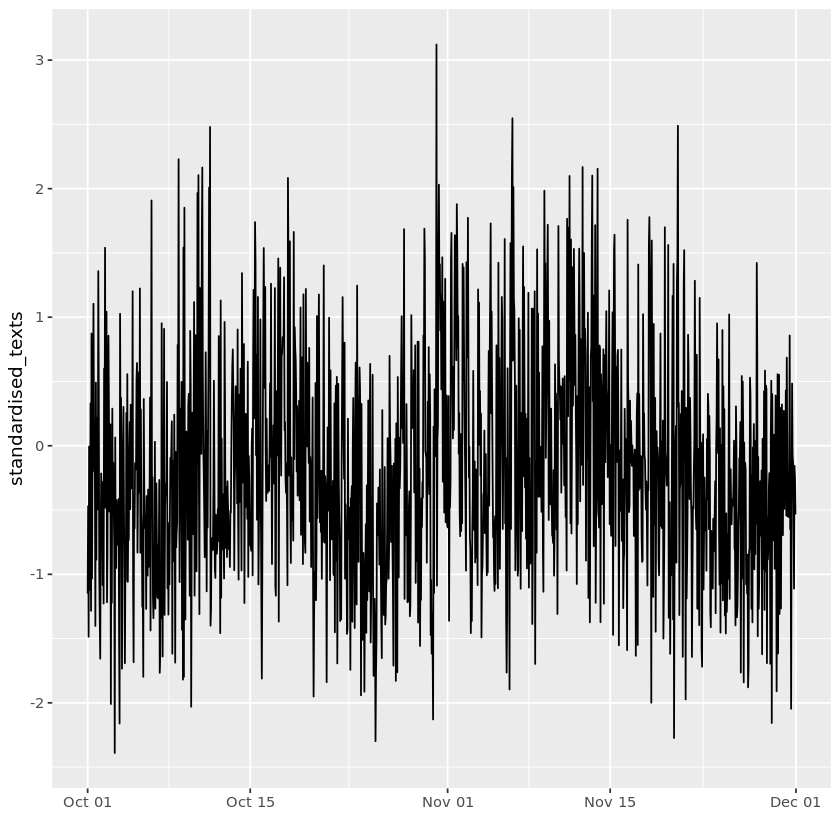

In [12]:
ggplot(standardised_plot, aes(x=chunk, y=standardised_texts, group = 1)) +
geom_line() +  xlab("")

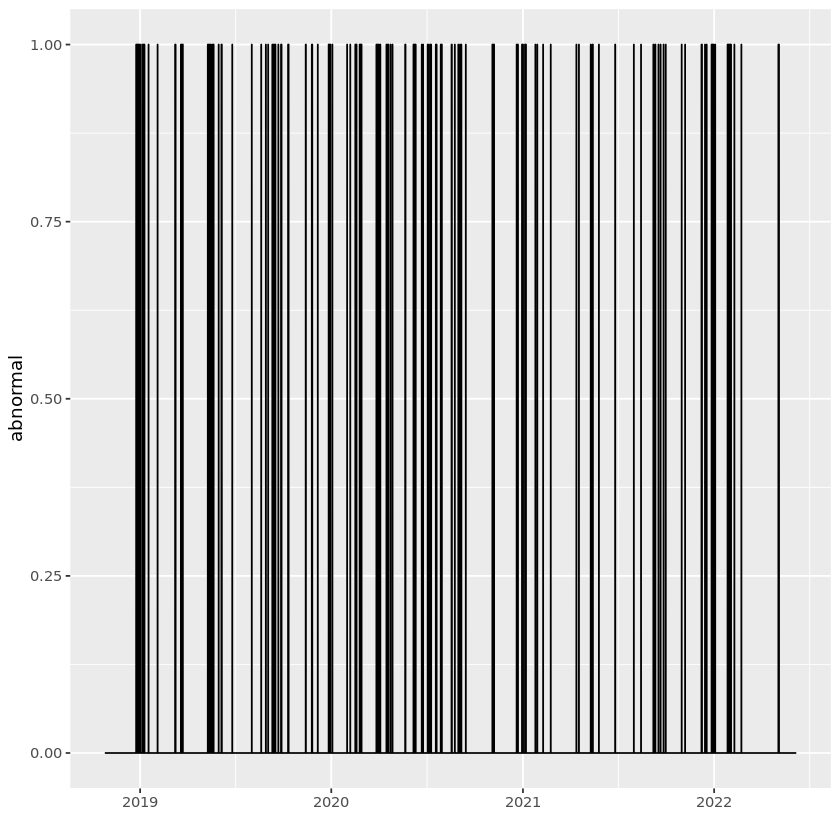

In [44]:
ggplot(standardised, aes(x=chunk, y=abnormal, group = 1)) +
geom_line() +  xlab("")

In [13]:
df_abnormals <- standardised %>% filter(abnormal == TRUE) 
df_abnormals

chunk,standardised_texts,abnormal
<dttm>,<dbl>,<dbl>
2018-12-24 11:00:00,2.813539,1
2018-12-24 13:00:00,2.503139,1
2018-12-24 16:00:00,2.694538,1
2018-12-24 18:00:00,2.597116,1
2018-12-24 19:00:00,2.673679,1
2018-12-24 20:00:00,2.533814,1
2018-12-24 23:00:00,2.746197,1
2018-12-25 00:00:00,2.624669,1
2018-12-25 01:00:00,2.508374,1


In [14]:
df_new <- df[-9]
head(df_new)

,chunk,texts,localtime,GMTtime,weekday,month,year,quarter
,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,2018-10-25 15:00:00,3,15:00:00,15:00:00,Thursday,10,2018,4
2,2018-10-25 16:00:00,3,16:00:00,16:00:00,Thursday,10,2018,4
3,2018-10-25 17:00:00,8,17:00:00,17:00:00,Thursday,10,2018,4
4,2018-10-25 18:00:00,9,18:00:00,18:00:00,Thursday,10,2018,4
5,2018-10-25 19:00:00,11,19:00:00,19:00:00,Thursday,10,2018,4
6,2018-10-25 20:00:00,24,20:00:00,20:00:00,Thursday,10,2018,4


In [15]:
df_new <- merge(x=df_new, y=standardised,by="chunk")

In [16]:
head(df_new, n=1)

,chunk,texts,localtime,GMTtime,weekday,month,year,quarter,standardised_texts,abnormal
,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,2018-10-25 15:00:00,3,15:00:00,15:00:00,Thursday,10,2018,4,-1.409536,0


In [17]:
df_scraping <- df_new[,c("chunk", "standardised_texts", "abnormal", "month","year")]

In [18]:
df_scraping <- df_scraping %>% mutate(day = day(chunk))
df_scraping$month <- tolower(month.abb[df_scraping$month])

In [19]:
head(df_scraping)

,chunk,standardised_texts,abnormal,month,year,day
,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<int>
1,2018-10-25 15:00:00,-1.4095363,0,oct,2018,25
2,2018-10-25 16:00:00,-2.2057631,0,oct,2018,25
3,2018-10-25 17:00:00,-1.4766641,0,oct,2018,25
4,2018-10-25 18:00:00,-0.9937495,0,oct,2018,25
5,2018-10-25 19:00:00,-0.9455626,0,oct,2018,25
6,2018-10-25 20:00:00,0.7105955,0,oct,2018,25


In [52]:
#write.csv(df_scraping, "../Data/df_scraping.csv")

In [21]:
abnormal_cutoffs

,chunk,cutoff
,<dttm>,<dbl>
82,2018-10-29 00:00:00,22.71975
250,2018-11-05 00:00:00,22.71975
418,2018-11-12 00:00:00,22.71975
586,2018-11-19 00:00:00,22.71975
754,2018-11-26 00:00:00,22.71975
922,2018-12-03 00:00:00,22.71975
1090,2018-12-10 00:00:00,22.71975
1258,2018-12-17 00:00:00,22.71975
1426,2018-12-24 00:00:00,22.71975


In [54]:
write.csv(abnormal_cutoffs, "../Data/abnormal_cutoffs.csv")

In [22]:
write.csv(abnormal_cutoffs_2sd, "../Data/abnormal_cutoffs_2sd.csv")
write.csv(abnormal_cutoffs_1.5sd, "../Data/abnormal_cutoffs_1.5sd.csv")

In [20]:
df_new <- df_new[,c("chunk", "standardised_texts","abnormal")]
df_new <- df_new[order(df_new$chunk, decreasing=TRUE),]

In [21]:
tail(df_new)

,chunk,standardised_texts,abnormal
,<dttm>,<dbl>,<dbl>
6,2018-10-25 20:00:00,0.7105955,0
5,2018-10-25 19:00:00,-0.9455626,0
4,2018-10-25 18:00:00,-0.9937495,0
3,2018-10-25 17:00:00,-1.4766641,0
2,2018-10-25 16:00:00,-2.2057631,0
1,2018-10-25 15:00:00,-1.4095363,0


In [24]:
df_new["1-hr"] <- shift(df_new$standardised_texts, 1)
df_new["2-hr"] <- shift(df_new$standardised_texts, 2)
df_new["3-hr"] <- shift(df_new$standardised_texts, 3)
df_new["4-hr"] <- shift(df_new$standardised_texts, 4)
df_new["5-hr"] <- shift(df_new$standardised_texts, 5)
df_new["6-hr"] <- shift(df_new$standardised_texts, 6)
df_new["7-hr"] <- shift(df_new$standardised_texts, 7)
df_new["8-hr"] <- shift(df_new$standardised_texts, 8)
df_new["9-hr"] <- shift(df_new$standardised_texts, 9)
df_new["10-hr"] <- shift(df_new$standardised_texts, 10)
df_new["11-hr"] <- shift(df_new$standardised_texts, 11)
df_new["12-hr"] <- shift(df_new$standardised_texts, 12)
df_new["13-hr"] <- shift(df_new$standardised_texts, 13)
df_new["14-hr"] <- shift(df_new$standardised_texts, 14)
df_new["15-hr"] <- shift(df_new$standardised_texts, 15)
df_new["16-hr"] <- shift(df_new$standardised_texts, 16)
df_new["17-hr"] <- shift(df_new$standardised_texts, 17)
df_new["18-hr"] <- shift(df_new$standardised_texts, 18)
df_new["19-hr"] <- shift(df_new$standardised_texts, 19)
df_new["20-hr"] <- shift(df_new$standardised_texts, 20)
df_new["21-hr"] <- shift(df_new$standardised_texts, 21)
df_new["22-hr"] <- shift(df_new$standardised_texts, 22)
df_new["23-hr"] <- shift(df_new$standardised_texts, 23)
df_new["24-hr"] <- shift(df_new$standardised_texts, 24)
df_new["25-hr"] <- shift(df_new$standardised_texts, 25)
df_new["26-hr"] <- shift(df_new$standardised_texts, 26)
df_new["27-hr"] <- shift(df_new$standardised_texts, 27)
df_new["28-hr"] <- shift(df_new$standardised_texts, 28)

df_new <- df_new[order(df_new$chunk),]
df_new <- df_new[29:(nrow(df_new)-1),]
df_new <- df_new %>% select(-2)
head(df_new)

,chunk,abnormal,1-hr,2-hr,3-hr,4-hr,5-hr,6-hr,7-hr,8-hr,⋯,19-hr,20-hr,21-hr,22-hr,23-hr,24-hr,25-hr,26-hr,27-hr,28-hr
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29,2018-10-26 19:00:00,0,-0.6010679,-1.3726190,-0.0247520,-0.4374796,0.7108556,1.8196562,0.3108767,-0.6507914,⋯,-0.5509926,0.3432454,-0.5376402,0.1196872,0.7105955,-0.9455626,-0.9937495,-1.4766641,-2.2057631,-1.4095363
30,2018-10-26 20:00:00,0,0.4171159,-0.6010679,-1.3726190,-0.0247520,-0.4374796,0.7108556,1.8196562,0.3108767,⋯,0.1497921,-0.5509926,0.3432454,-0.5376402,0.1196872,0.7105955,-0.9455626,-0.9937495,-1.4766641,-2.2057631
31,2018-10-26 21:00:00,0,-0.4045199,0.4171159,-0.6010679,-1.3726190,-0.0247520,-0.4374796,0.7108556,1.8196562,⋯,-0.0304761,0.1497921,-0.5509926,0.3432454,-0.5376402,0.1196872,0.7105955,-0.9455626,-0.9937495,-1.4766641
32,2018-10-26 22:00:00,0,-0.9145045,-0.4045199,0.4171159,-0.6010679,-1.3726190,-0.0247520,-0.4374796,0.7108556,⋯,-0.6507914,-0.0304761,0.1497921,-0.5509926,0.3432454,-0.5376402,0.1196872,0.7105955,-0.9455626,-0.9937495
33,2018-10-26 23:00:00,0,-0.3375264,-0.9145045,-0.4045199,0.4171159,-0.6010679,-1.3726190,-0.0247520,-0.4374796,⋯,1.4907880,-0.6507914,-0.0304761,0.1497921,-0.5509926,0.3432454,-0.5376402,0.1196872,0.7105955,-0.9455626
34,2018-10-27 00:00:00,0,1.0419964,-0.3375264,-0.9145045,-0.4045199,0.4171159,-0.6010679,-1.3726190,-0.0247520,⋯,-1.1927199,1.4907880,-0.6507914,-0.0304761,0.1497921,-0.5509926,0.3432454,-0.5376402,0.1196872,0.7105955


In [25]:
write.csv(df_new, "../Data/standardised_dt_df.csv")

In [59]:
write.csv(df_new, "../Data/standardised_dt_df_6hr.csv")

In [65]:
df_full <- readRDS('../Data/Full_data.rds')
df_full <- df_full[order(df_full$chunk, decreasing=TRUE),]
head(df_full, n=2)

,chunk,texts,temp_weighted,cloud_cover_weighted,rainfall_weighted,polarity,standardised_texts,abnormal,daily_policy_index
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>
31687,2022-06-06 21:00:00,144,13.40305,62.30690,0.0228837,0.126058810840715,-1.030201,0,237.37
31686,2022-06-06 20:00:00,188,14.23738,60.13144,0.0000000,0.126058810840715,1.293537,0,237.37


In [66]:
df_full["1_hr_std"] <- shift(df_full$standardised_texts, 1)
df_full["2_hr_std"] <- shift(df_full$standardised_texts, 2)
df_full["3_hr_std"] <- shift(df_full$standardised_texts, 3)
df_full["4_hr_std"] <- shift(df_full$standardised_texts, 4)
df_full["5_hr_std"] <- shift(df_full$standardised_texts, 5)
df_full["6_hr_std"] <- shift(df_full$standardised_texts, 6)
df_full["7_hr_std"] <- shift(df_full$standardised_texts, 7)
df_full["8_hr_std"] <- shift(df_full$standardised_texts, 8)
df_full["9_hr_std"] <- shift(df_full$standardised_texts, 9)
df_full["10_hr_std"] <- shift(df_full$standardised_texts, 10)
df_full["11_hr_std"] <- shift(df_full$standardised_texts, 11)
df_full["12_hr_std"] <- shift(df_full$standardised_texts, 12)
df_full["13_hr_std"] <- shift(df_full$standardised_texts, 13)
df_full["14_hr_std"] <- shift(df_full$standardised_texts, 14)
df_full["15_hr_std"] <- shift(df_full$standardised_texts, 15)
df_full["16_hr_std"] <- shift(df_full$standardised_texts, 16)
df_full["17_hr_std"] <- shift(df_full$standardised_texts, 17)
df_full["18_hr_std"] <- shift(df_full$standardised_texts, 18)
df_full["19_hr_std"] <- shift(df_full$standardised_texts, 19)
df_full["20_hr_std"] <- shift(df_full$standardised_texts, 20)
df_full["21_hr_std"] <- shift(df_full$standardised_texts, 21)
df_full["22_hr_std"] <- shift(df_full$standardised_texts, 22)
df_full["23_hr_std"] <- shift(df_full$standardised_texts, 23)
df_full["24_hr_std"] <- shift(df_full$standardised_texts, 24)
df_full["25_hr_std"] <- shift(df_full$standardised_texts, 25)
df_full["26_hr_std"] <- shift(df_full$standardised_texts, 26)
df_full["27_hr_std"] <- shift(df_full$standardised_texts, 27)
df_full["28_hr_std"] <- shift(df_full$standardised_texts, 27)

df_full["1_hr"] <- shift(df_full$texts, 1)
df_full["2_hr"] <- shift(df_full$texts, 2)
df_full["3_hr"] <- shift(df_full$texts, 3)
df_full["4_hr"] <- shift(df_full$texts, 4)
df_full["5_hr"] <- shift(df_full$texts, 5)
df_full["6_hr"] <- shift(df_full$texts, 6)
df_full["7_hr"] <- shift(df_full$texts, 7)
df_full["8_hr"] <- shift(df_full$texts, 8)
df_full["9_hr"] <- shift(df_full$texts, 9)
df_full["10_hr"] <- shift(df_full$texts, 10)
df_full["11_hr"] <- shift(df_full$texts, 11)
df_full["12_hr"] <- shift(df_full$texts, 12)
df_full["13_hr"] <- shift(df_full$texts, 13)
df_full["14_hr"] <- shift(df_full$texts, 14)
df_full["15_hr"] <- shift(df_full$texts, 15)
df_full["16_hr"] <- shift(df_full$texts, 16)
df_full["17_hr"] <- shift(df_full$texts, 17)
df_full["18_hr"] <- shift(df_full$texts, 18)
df_full["19_hr"] <- shift(df_full$texts, 19)
df_full["20_hr"] <- shift(df_full$texts, 20)
df_full["21_hr"] <- shift(df_full$texts, 21)
df_full["22_hr"] <- shift(df_full$texts, 22)
df_full["23_hr"] <- shift(df_full$texts, 23)
df_full["24_hr"] <- shift(df_full$texts, 24)
df_full["25_hr"] <- shift(df_full$texts, 25)
df_full["26_hr"] <- shift(df_full$texts, 26)
df_full["27_hr"] <- shift(df_full$texts, 27)
df_full["28_hr"] <- shift(df_full$texts, 28)

df_full <- df_full[order(df_full$chunk),]
df_full <- df_full[29:(nrow(df_full)-1),]
head(df_full)

,chunk,texts,temp_weighted,cloud_cover_weighted,rainfall_weighted,polarity,standardised_texts,abnormal,daily_policy_index,1_hr_std,⋯,19_hr,20_hr,21_hr,22_hr,23_hr,24_hr,25_hr,26_hr,27_hr,28_hr
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
29,2018-10-26 19:00:00,17,6.034263,21.52583,0,0.0432121742867696,0.4171159,0,131.03,-0.6010679,⋯,6,17,18,22,24,11,9,8,3,3
30,2018-10-26 20:00:00,15,5.561813,16.28374,0,0.0432121742867696,-0.4045199,0,131.03,0.4171159,⋯,7,6,17,18,22,24,11,9,8,3
31,2018-10-26 21:00:00,15,5.399833,17.53819,0,0.0432121742867696,-0.9145045,0,131.03,-0.4045199,⋯,5,7,6,17,18,22,24,11,9,8
32,2018-10-26 22:00:00,19,4.787232,10.76873,0,0.0432121742867696,-0.3375264,0,131.03,-0.9145045,⋯,1,5,7,6,17,18,22,24,11,9
33,2018-10-26 23:00:00,21,4.534415,11.67290,0,0.0432121742867696,1.0419964,0,131.03,-0.3375264,⋯,2,1,5,7,6,17,18,22,24,11
34,2018-10-27 00:00:00,5,4.079211,14.18510,0,0.0203183999705964,-0.8932260,0,112.53,1.0419964,⋯,0,2,1,5,7,6,17,18,22,24


In [67]:
saveRDS(df_full, '../Data/Full_data.rds')
write.csv(df_full, '../Data/Full_data.csv')

In [2]:
cutoffs <- read.csv("../Data/abnormal_cutoffs.csv")

In [6]:
cutoffs <- cutoffs %>% mutate(chunk = as.POSIXct(chunk, format="%Y-%m-%d %H:%M:%S",tz="GMT"), hour = hour(chunk), weekday = weekdays(chunk)) %>% select(chunk, cutoff, hour, weekday)

In [7]:
cutoffs <- cutoffs %>% filter(chunk >= "2022-01-01" & chunk < "2022-04-01")

In [11]:
cutoffs <- cutoffs %>% distinct(cutoff, .keep_all = TRUE) %>% select(-chunk)
cutoffs

cutoff,hour,weekday
<dbl>,<int>,<chr>
209.91404,0,Monday
151.39735,1,Monday
117.24117,2,Monday
72.25430,3,Monday
47.69524,4,Monday
42.04006,5,Monday
39.78373,6,Monday
76.63943,7,Monday
83.96272,8,Monday


In [12]:
write.csv(cutoffs, '../Data/Q1_22_cutoffs.csv')